<center><h2>Correlation between President Trump's Tweet VADER Sentiment and NASDAQ</h2></center>
<hr>

### Author

Joey Poh (@joeypohie)

from class Thu 7.00pm

### Executive Summary

To investigate how Trump's Tweet VADER sentiment affected NASDAQ, sentiment analysis using VADER was performed on Trump's historical tweets. Visualisation tools were also employed. The VADER compound was plotted against daily NASDAQ movement in a scatter plot. Further analysis was done using clustering. A bar chart was used to find the proportion of data that had a positive correlation between the 2 variables.

The hypothesis that the VADER compound Trump's tweets had a clear correlation between daily NASDAQ movement was rejected. This investigation suggests that there may be a positive correlation between the 2 variables, but cannot conclude that this is indeed the case. 

### Research Topic & Hypothesis

In the week of 6 May 2019, President Donald Trump tweeted 102 words that erased $1.36 trillion from global stocks. Claiming that he would raise tariffs on Chinese goods, Trump caused worries surrounding U.S-China trade relations to reemerge. Volatility roared back with a vengance - the Cboe Volatility Index rose 50% in two days, breaching 20 for the first time since January. Investors were shocked at the sudden turn of events, myself included. 

This report intends to study the impact that President Trump's tweets have on NASDAQ. Data from the time Trump became President elect to present was collected in the form of CSV files. This data includes President Trump's tweets and NASDAQ data.

In order to find the relationship between the 2 variables, sentiment analysis was done on Trump's tweets and plotted against NASDAQ's daily movement.

It is hypothesised that President Trump's tweets have a significant impact on NASDAQ. There should be a strong positive correlation between the VADER compound and NASDAQ's daily movement.



**Literature / Articles of reference:**
- Each Word of Trump's Tariff Tweets Wiped $13 Billion Off Stocks ([https://www.bloomberg.com/news/articles/2019-05-08/each-word-of-trump-s-tariff-tweets-wiped-13-billion-off-stocks](127.0.0.1)) retrieved on 10 June 2019

**Datasets used:**
- President Trump Tweets since he became President elect ([http://www.trumptwitterarchive.com/archive](127.0.0.1)) retrieved on 10 June 2019

- NASDAQ Data ([https://www.nasdaq.com/symbol/csv/interactive-chart](127.0.0.1)) retrieved on 10 June 2019



### Investigation

**Importing libraries**

In [1045]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import re
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.cluster import KMeans

import seaborn as sns
from sklearn.metrics import confusion_matrix

**Import and Cleaning Data**

*President Trump Tweets*

In [1046]:
tweets_data=pd.read_csv('Trump_Tweets.csv',encoding='ISO-8859-1')
tweets_data.head()

,text,date_created_at,time_created_at,favorite_count,id_str
0,Starting tomorrow it's going to be #AmericaFir...,11/7/16,5:10:00 PM,36087,7.960000e+17
1,Just landed in North Carolina- heading to the ...,11/7/16,7:30:00 PM,40976,7.960000e+17
2,On my way! https://t.co/6L2ILD6r8h,11/7/16,7:31:00 PM,26336,7.960000e+17
3,I love you North Carolina- thank you for your ...,11/7/16,9:03:00 PM,31000,7.960000e+17
4,'Why Trump' https://t.co/RpwIYB7aOV,11/7/16,9:32:00 PM,18057,7.960000e+17


In [1047]:
def regex(x):
    special_chars_p = "[.®'&$’\"\-()#@!?/:]"
    s1 = re.sub(special_chars_p, '',x)  
    return(s1)

tweets_data['tweet_c1']=tweets_data['text'].apply(regex)

stemmer = PorterStemmer()

def stem_sentences(sentence):
    tokens = sentence.lower().split()
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    return ' '.join(stemmed_tokens)

tweets_data['tweet_c2']=tweets_data['tweet_c1'].apply(stem_sentences)

tweets_data['tweet_c2'].head()
    
stop=stopwords.words('english')

tweets_data['tweet_c2'].apply(lambda x: [item for item in x if item not in stop])

tweets_data['tweet_cleaned'] = tweets_data['tweet_c2'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

tweets_data.drop(columns=['tweet_c1','tweet_c2'],inplace=True)

def regex_date(y):
    special_chars_p = "-"
    s1 = re.sub(special_chars_p, '/',y)  
    return(s1)

tweets_data['Date']=tweets_data['date_created_at'].apply(regex_date)

tweets_data.head()

,text,date_created_at,time_created_at,favorite_count,id_str,tweet_cleaned,Date
0,Starting tomorrow it's going to be #AmericaFir...,11/7/16,5:10:00 PM,36087,7.960000e+17,start tomorrow go americafirst thank great mor...,11/7/16
1,Just landed in North Carolina- heading to the ...,11/7/16,7:30:00 PM,40976,7.960000e+17,land north carolina head js dorton arena see s...,11/7/16
2,On my way! https://t.co/6L2ILD6r8h,11/7/16,7:31:00 PM,26336,7.960000e+17,way httpstco6l2ild6r8h,11/7/16
3,I love you North Carolina- thank you for your ...,11/7/16,9:03:00 PM,31000,7.960000e+17,love north carolina thank amaz support get htt...,11/7/16
4,'Why Trump' https://t.co/RpwIYB7aOV,11/7/16,9:32:00 PM,18057,7.960000e+17,whi trump httpstcorpwiyb7aov,11/7/16


*NASDAQ Data*

In [1048]:
nasdaq=pd.read_csv('NASDAQ_Data.csv')
nasdaq.head()

,Date,Open,High,Low,Close,Volume
0,11/8/16,23.84,24.410,23.73,24.26,190988.0
1,11/9/16,23.95,24.900,23.59,24.89,170208.0
2,11/10/16,25.00,25.455,24.25,24.38,176457.0
3,11/11/16,24.39,25.810,24.39,25.54,242595.0
4,11/14/16,25.91,25.980,25.38,25.40,148580.0


In [1049]:
nasdaq['Date']=nasdaq['Date'].apply(regex_date)

**Sentiment Analysis of Tweets**

In [1050]:
sid = SentimentIntensityAnalyzer()

def vader(sentence):
    vaded=sid.polarity_scores(sentence)
    return vaded['compound']

tweets_data['VADER_compound']=tweets_data['tweet_cleaned'].apply(vader)

tweets_data.head()

,text,date_created_at,time_created_at,favorite_count,id_str,tweet_cleaned,Date,VADER_compound
0,Starting tomorrow it's going to be #AmericaFir...,11/7/16,5:10:00 PM,36087,7.960000e+17,start tomorrow go americafirst thank great mor...,11/7/16,0.7650
1,Just landed in North Carolina- heading to the ...,11/7/16,7:30:00 PM,40976,7.960000e+17,land north carolina head js dorton arena see s...,11/7/16,0.0000
2,On my way! https://t.co/6L2ILD6r8h,11/7/16,7:31:00 PM,26336,7.960000e+17,way httpstco6l2ild6r8h,11/7/16,0.0000
3,I love you North Carolina- thank you for your ...,11/7/16,9:03:00 PM,31000,7.960000e+17,love north carolina thank amaz support get htt...,11/7/16,0.8555
4,'Why Trump' https://t.co/RpwIYB7aOV,11/7/16,9:32:00 PM,18057,7.960000e+17,whi trump httpstcorpwiyb7aov,11/7/16,0.0000


**Calculating daily NASDAQ Movement**

In [1051]:
nasdaq['Movement']=nasdaq['Close']-nasdaq['Open']

nasdaq.head(3)

,Date,Open,High,Low,Close,Volume,Movement
0,11/8/16,23.84,24.410,23.73,24.26,190988.0,0.42
1,11/9/16,23.95,24.900,23.59,24.89,170208.0,0.94
2,11/10/16,25.00,25.455,24.25,24.38,176457.0,-0.62


**Data Filtration**

Filtering for tweets that may affect NASDAQ 

In [1052]:
keywords='trade|market|stock|tariff|economy|nasdaq|dia|bluechip|cryptocurrency|dow jones|bear run|bull run|economic|finance|GDP|growth|inflation|industry|poverty|recession|sector|slump|supply|demand|wealth'

tweets_data=tweets_data.copy()

tweets_data.reset_index(drop=True)

tweets_data=tweets_data[(tweets_data['tweet_cleaned'].str.contains(keywords))
                       &(~(tweets_data['VADER_compound']==0))]

df=pd.merge(tweets_data,nasdaq,on='Date',how='outer')

df.dropna(axis=0,inplace=True)

df.drop(columns=['text','time_created_at','favorite_count','id_str','High','Low','Open','Close','Volume','Date'],inplace=True)

df.tail()

,date_created_at,tweet_cleaned,VADER_compound,Movement
815,6/5/19,ñhous republican support presid tariff mexico ...,0.8934,-0.20
816,6/5/19,talk mexico resum tomorrow understand agreemen...,0.5574,-0.20
817,6/6/19,ñthe presid ha receiv glow review british medi...,-0.5106,-0.05
818,6/7/19,china subsid product order continu sold usa ma...,-0.3818,-0.07
819,6/7/19,abl make deal mexico amp; good chanc begin pur...,0.3612,-0.07


**Visualisation of NASDAQ Closing Results against VADER Compound**

Text(0, 0.5, 'Movement')

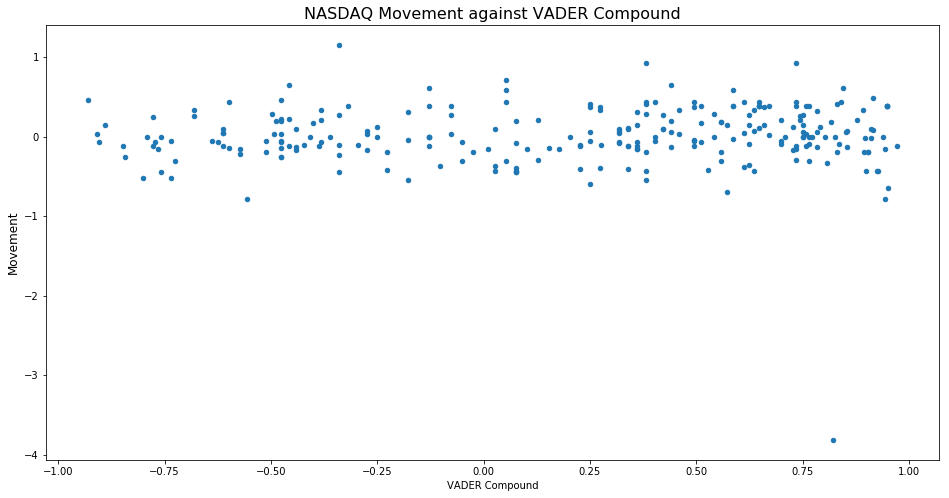

In [1053]:
fig, ax1 = plt.subplots()
df.plot(kind='scatter', x='VADER_compound', y='Movement', ax=ax1, figsize=(16,8))


ax1.set_title('NASDAQ Movement against VADER Compound',fontsize=16)

plt.xlabel("VADER Compound")

#plt.yticks(range(95,100,1))
plt.ylabel("Movement", fontsize=12)

From the scatter plot, the hypothesis - there should be a strong positive correlation between the VADER compound and NASDAQ's daily movement - has been rejected. The scatter plot was too random to draw any insightful information.

However, it dawned on me that clustering may be able to provide new insights. 

**Further Analysis by Clustering**

In [1067]:
f=['VADER_compound','Movement']

X = df[f]

model = KMeans(n_clusters=4, random_state=0)

kmeans = model.fit(X)

print(kmeans)

print(kmeans.labels_)

X_results=X.copy()

X_results['label'] = kmeans.labels_

X_results.head()

new_df = df.copy().merge(X_results, on = ['VADER_compound', 'Movement'])

new_df

new_df[new_df['label'] == 0].head(1)
new_df[new_df['label'] == 1].head(1)
new_df[new_df['label'] == 2].head(1)
new_df[new_df['label'] == 3].head(1)

print(kmeans.cluster_centers_)

centroid_df_cols = ['VADER_compound', 'Movement']

centroids_df = pd.DataFrame(kmeans.cluster_centers_, columns=centroid_df_cols)

centroids_df['label'] = centroids_df.index

centroids_df

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)
[2 3 3 3 3 3 1 2 1 2 3 1 2 2 3 2 1 1 3 2 2 2 3 1 3 2 2 2 2 2 2 2 3 2 2 2 2
 2 2 3 2 3 3 1 1 1 1 1 1 1 3 2 1 1 1 1 2 3 1 2 2 3 3 2 3 1 2 2 1 3 2 3 3 3
 3 1 1 3 2 2 3 3 3 1 3 2 2 2 1 2 3 3 1 2 3 2 1 1 2 3 2 3 3 2 1 3 1 2 2 3 2
 2 2 1 1 2 2 1 1 2 2 2 1 3 2 2 1 2 2 3 3 3 1 3 1 2 3 3 1 2 1 1 2 3 2 1 3 3
 3 1 3 1 2 3 3 3 1 1 1 1 1 1 2 0 3 3 3 2 3 3 3 3 2 3 3 2 3 2 3 2 1 3 1 2 1
 2 3 3 3 3 1 2 3 1 3 1 2 3 3 3 3 3 1 3 1 1 2 2 3 3 1 3 3 3 1 3 3 1 2 1 1 1
 2 3 3 3 3 3 2 3 3 3 3 3 3 3 3 3 2 3 3 3 2 3 3 3 3 2 3 1 2 1 2 3 3 3 3 1 2
 2 1]
[[ 0.8225     -3.81      ]
 [ 0.33648235 -0.23029412]
 [-0.47904699  0.0173494 ]
 [ 0.65706697  0.19944954]]


,VADER_compound,Movement,label
0,0.822500,-3.810000,0
1,0.336482,-0.230294,1
2,-0.479047,0.017349,2
3,0.657067,0.199450,3


*Comparative Visualisation*

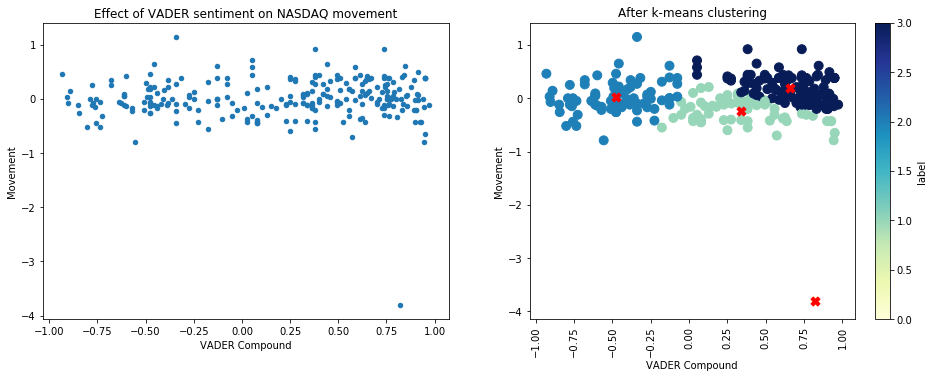

In [1068]:
fig = plt.figure(figsize=(16, 12))
ax1 = fig.add_subplot(221)

df.plot(kind='scatter', x='VADER_compound',y='Movement', ax=ax1)
ax1.set_title('Effect of VADER sentiment on NASDAQ movement')
ax1.set_xlabel("VADER Compound")

ax2 = fig.add_subplot(222)

X_results.plot(kind='scatter', x='VADER_compound',y='Movement', 
               c='label', colormap='YlGnBu', ax=ax2,marker="o", s=80)

centroids_df.plot(kind='scatter', x='VADER_compound',y='Movement', color='red', ax=ax2,
                marker="X", s=80,)

ax2.set_title('After k-means clustering')
ax2.set_xlabel("VADER Compound")

plt.xticks(rotation=90)
plt.show()

Unfortunately, performing clustering did not provide insightful data. Therefore, I decided to plot the number of incidences of different types of correlations to see if there was a particular correlation that stood out.

**Bar Charting**

In [1056]:
Negative_sentiment_negative_movement=0
Negative_sentiment_positive_movement=0
Positive_sentiment_positive_movement=0
Positive_sentiment_negative_movement=0

for i in range(len(df)): 
    
    if df.iloc[i]['VADER_compound']<0:
        if df.iloc[i]['Movement']<0:
            Negative_sentiment_negative_movement+=1
            
    if df.iloc[i]['VADER_compound']<0:
        if df.iloc[i]['Movement']>0:
            Negative_sentiment_positive_movement+=1
            
    if df.iloc[i]['VADER_compound']>0:
        if df.iloc[i]['Movement']>0:
            Positive_sentiment_positive_movement+=1
            
    if df.iloc[i]['VADER_compound']>0:
        if df.iloc[i]['Movement']<0:
            Positive_sentiment_negative_movement+=1
    
print(Negative_sentiment_negative_movement)
print(Negative_sentiment_positive_movement)
print(Positive_sentiment_positive_movement)
print(Positive_sentiment_negative_movement)

categories = pd.DataFrame([['Negative sentiment=negative movement',Negative_sentiment_negative_movement], 
                           ['Negative sentiment=positive movement', Negative_sentiment_positive_movement],
                          ['Positive sentiment=positive movement',Positive_sentiment_positive_movement], 
                          ['Positive sentiment=negative movement',Positive_sentiment_negative_movement]],
                          columns=list('AB'))

categories

47
35
88
77


,A,B
0,Negative sentiment=negative movement,47
1,Negative sentiment=positive movement,35
2,Positive sentiment=positive movement,88
3,Positive sentiment=negative movement,77


Text(0.5, 1.0, 'Correlation')

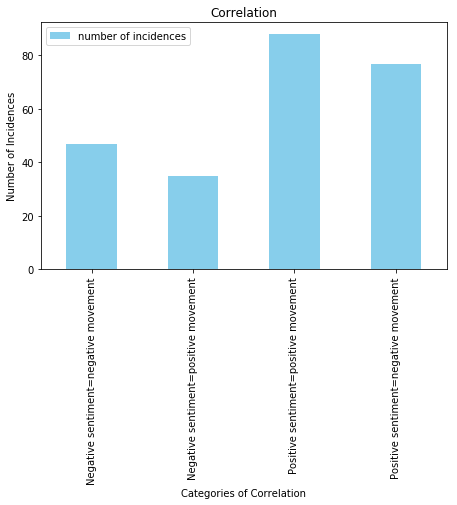

In [1057]:
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(221)

categories.plot(kind='bar', x='A', y='B', ax=ax, color='skyblue',label='number of incidences')

ax.set_ylabel('Number of Incidences')
ax.set_xlabel('Categories of Correlation')
ax.set_title('Correlation')

In [1058]:
positive_correlation_count=categories['B'].iloc[0]+categories['B'].iloc[2]

negative_correlation_count=categories['B'].iloc[1]+categories['B'].iloc[3]

total_count=categories['B'].iloc[0]+categories['B'].iloc[2]+categories['B'].iloc[1]+categories['B'].iloc[3]

proportion_positive=positive_correlation_count/total_count*100

proportion_negative=negative_correlation_count/total_count*100

print(proportion_positive)
print(proportion_negative)

54.655870445344135
45.34412955465587


### Insights and Evaluation 

- From the scatter plots and clustering results, it is evident that there is no clear correlation between the VADER compound and NASDAQ movement.


- However, 54.7% of the results show a positive correlation between the 2 variables, therefore suggesting that there is a correlation between the 2, albeit weak. 


- Since there the results of the investigation are not significant, the hypothesis has been rejected. 


**Plausible Improvements to the Investigation**

- President Trump's tweets were filtered with a limtied set of keywords. Having a better filtration method may make the results of the investigation more insightful and reliable.

**Plausible Extensions to the Investigation**

- There are various factors that affect NASDAQ movement. It would be interesting if this investigation could consider more dimensions. 


- Considering the US's international relations, tweets mentioning different countries/topics may have various degrees of impact on NASDAQ movement. This extension would enhance the accuracy of the investigation. 


- Predicting NASDAQ's movements would also be informative for traders.